In [260]:
import pandas as pd 
import numpy as np
from collections import Counter, OrderedDict
import gzip
import os
from multiprocessing import Pool
import subprocess


import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 

Give - https://github.com/Zhong-Lab-UCSD/Genomic-Interactive-Visualization-Engine/blob/master/tutorials/0-shortexample.md

HiCtool - https://github.com/Zhong-Lab-UCSD/HiCtool/blob/master/tutorial/data-preprocessing.md

## Loading chromsizes file 

In [95]:
# Loading chromosome sizes 
chromsize_fn = '/gpfs/data01/glasslab/home/joreyna/projects/CSE283/Project/ref/chromsize.hg38.txt'
chromsizes = pd.read_table(chromsize_fn, sep='\t', names=['chrom', 'size'])
chromsizes.set_index('chrom', inplace=True)

# Excluding non-human chromosomes 
chroms = list(range(1, 23)) + ['X', 'Y']
chroms = ['chr{}'.format(x) for x in chroms]
chromsizes = chromsizes[chromsizes.index.isin(chroms)]

In [251]:
chromsizes

,size,bins
chrom,,
chr1,248956422,"(0, 40000, 80000, 120000, 160000, 200000, 2400..."
chr2,242193529,"(0, 40000, 80000, 120000, 160000, 200000, 2400..."
chr3,198295559,"(0, 40000, 80000, 120000, 160000, 200000, 2400..."
chr4,190214555,"(0, 40000, 80000, 120000, 160000, 200000, 2400..."
chr5,181538259,"(0, 40000, 80000, 120000, 160000, 200000, 2400..."
chr6,170805979,"(0, 40000, 80000, 120000, 160000, 200000, 2400..."
chr7,159345973,"(0, 40000, 80000, 120000, 160000, 200000, 2400..."
chr8,145138636,"(0, 40000, 80000, 120000, 160000, 200000, 2400..."
chr9,138394717,"(0, 40000, 80000, 120000, 160000, 200000, 2400..."


## Analyzing bin counts 

In [186]:
def decide_read_bin(start, end, bin_size):
    """
    Decide what bin to use for read with start end. 
    
    """
    
    mid = np.mean([start, end])
    cbin = int(np.floor(mid/bin_size))
    
    return(cbin)

def decide_read_pair_bin(startA, endA, startB, endB, bin_size):
    """
    Decide what bin to use for read pair. 
    
    """

    binA = decide_read_bin(startA, endA, bin_size)
    binB = decide_read_bin(startB, endB, bin_size)
    
    return([binA, binB])

In [ ]:
def chrom_num(x):
    """
    Assign a chromosome number. 
    
    """
    if x not in ['chrX', 'chrY']:
        x = int(x.replace('chr', ''))
    elif x == 'chrX':
        x = 23
    elif x == 'chrY':
        x = 24
        
    return(x)

def chrom_key(x):
    """
    Generate a chromsome key for sorting. 
    
    """
    
    return(chrom_num(x[0]), chrom_num(x[2]), x[1], x[3])

In [313]:
read_pairs_fn = '/gpfs/data01/glasslab/home/joreyna/projects/CSE283/Project/data/GSE122690/GSM3478205_HEK_iMARGI.bedpe.gz'
bin_size = 1000000
all_interactions_fn = read_pairs_fn.replace('bedpe.gz', 'bs_{}.contacts.gz'.format(bin_size))

In [316]:
if not os.path.exists(all_interactions_fn):
    contact_map = Counter()
    with gzip.open(read_pairs_fn) as f:
        for i, line in enumerate(f):
            line = line.decode().strip()
            chrA, startA, endA, chrB, startB, endB, _, _, _,_ = line.split('\t')
            startA, endA, startB, endB = [int(x) for x in (startA, endA, startB, endB)]
            binA, binB = decide_read_pair_bin(startA, endA, startB, endB, bin_size)

            contact_key = (chrA, binA, chrB, binB)

            if chromA in chroms and chromB in chroms: 
                contact_map[contact_key] += 1 

            if i % 1000000 == 0:
                print(i)
                

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000


In [ ]:
# Temp code to remove non-human chromes 
temp_contact_map = {}
for k, v in contact_map.items():
    if k[0] in chroms and k[2] in chroms: 
        temp_contact_map[k] = v
        

In [322]:
contact_map = temp_contact_map

In [323]:
# Write the contact map in sorted order by chromsome and positions 
if not os.path.exists(all_interactions_fn):
    
    # Getting and sorting contact keys 
    contact_keys = contact_map.keys()
    sorted_keys = sorted(contact_keys, key=chrom_key)
    
    with gzip.open(all_interactions_fn, 'w') as f: 
        for key in sorted_keys: 
            counts = contact_map[key]
            msg = list(key) + [counts]
            msg = '\t'.join([str(x) for x in msg]) + '\n'
            f.write(msg.encode())

## Experimenting with a multiprocessing method 

https://docs.python.org/3/library/multiprocessing.html

## Plotting the heatmap 

In [303]:
def filter_write_contact_data(fn, output_fn, chromA, chromB):
    """
    Filter the data by chromA and chromB and write.
    
    """
    
    if not os.path.exists(output_fn):
        with gzip.open(fn) as all_contacts:
            with gzip.open(output_fn, 'w') as flt_contacts:
            
                for line in all_contacts: 

                    info = line.decode().strip()
                    chrA, binA, chrB, binB, counts = info.split('\t')    

                    if chrA == chromA and chrB == chromB: 
                        flt_contacts.write(line)


# Writing contact data for chromA and chromB 
chromA, chromB = ('chr9', 'chr9')
ext = '{}_{}.contacts.gz'.format(chromA, chromB)
flt_interactions_fn = all_interactions_fn.replace('contacts.gz', ext) 
filter_write_contact_data(all_interactions_fn, flt_interactions_fn, chromA, chromB)

In [304]:
# Loading the data for chromA and chromB
contact_data = pd.read_table(flt_interactions_fn, names=['chrA', 'binA', 'chrB', 'binB', 'counts'])

In [305]:
# Generating the contact matrix 
max_binA = contact_data.binA.max()
max_binB = contact_data.binB.max()
contact_matrix = np.zeros((max_binA + 1, max_binB + 1))
for (chrA, binA, chrB, binB, count) in contact_data.values:
    contact_matrix[binA, binB] = count


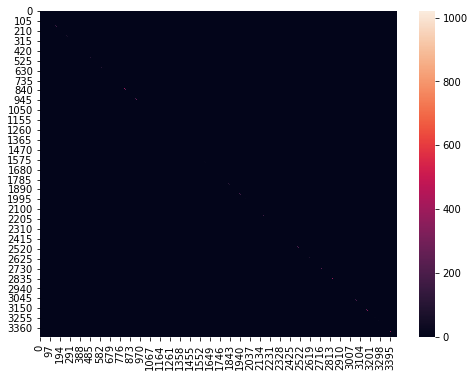

In [310]:
fig,ax = plt.subplots(figsize=(8,6))
sns.heatmap(contact_matrix)